# Introduction
The objective of this study is to use convolutional neural network (CNN) to generate a cancer classifier. Model fitting and hyperparameter tuning will be performed to optimize results and best accuracy in cancer classification.   
  
The dataset is provided by Kaggle via 'Histopathologic Cancer Detection' competition. It contains small patches of digital pathology scans and the objective is to create an algorithm to identify metastatic cancer in the image patches.

## Overview
The study will follow the structure below:
1. Review contents and structure of data. Clean and prepare data for analysis (drop missing values, number of features, length and types of data, etc), as well as perform EDA.
2. Generate data, choose model, and fit
4. Hyperparameter tuning to get best results
5. Conclusion (Discussion of results, areas of improvement)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import itertools
import shutil
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.callbacks import ReduceLROnPlateau


from numpy.random import seed
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import os

# Set seed for reproducibility of results
seed(1234)


In [2]:
X_train = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

In [3]:
X_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Note that each id does not have the .tif extension. It's possible that this may impede the classification process and may require manually adding the extension for each id.

In [4]:
X_train.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
X_train.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

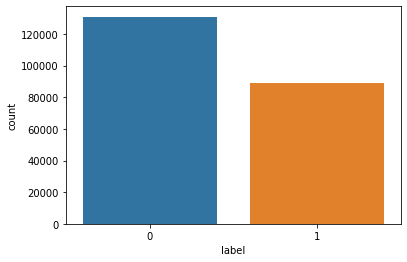

In [7]:
sns.countplot(x = 'label', data = X_train)

Data has 220025 entries with no missing values. There are two columns in the dataset, where one 'id' that represents the tissue/cell, and 'label' which represents whether the tissue is cancerous or not. Here, 0 is non-cancerous and 1 is cancerous.  
  
The distribution of each label seems to be skewed slightly to 0 (non-cancerous cell). This is helpful to keep in mind when viewing our final results. For indexing and manipulation purposes, we will save the labels as string values.

In [8]:
X_train['label'] = X_train['label'].astype('str')
print(type(X_train['label'][0]))

<class 'str'>


To get a general idea of what the image looks like, let's take a brief inspection of one of the images.

In [19]:
#View a sample image
Image.open(('/histopathologic-cancer-detection/train/') + os.listdir('histopathologic-cancer-detection/train')[10])

FileNotFoundError: [Errno 2] No such file or directory: '/histopathologic-cancer-detection/train/00016a638ed77529609ac61479dc7ee99a6f3711.tif'

## Model fitting and classification  
### Procedure  
This part will follow the steps below:  
1. Generate batches of tensor image data using ImageDataGenerator from the keras package.
2. Define functions for early stopping and extraction of the best performing model.
3. Initiate CNN (feature maps), add convolution, max pooling, dense and flatten layers. 
4. Compile using Adam optimizer and binary crossentropy loss function.
5. Fit the dataset.  

In [12]:
# Split data to training and validation sets
lab = X_train['label']
x_train, x_val = train_test_split(X_train, test_size = 0.2, random_state = 124)

print(len(x_train), len(x_val))
print(x_train.shape, x_val.shape)
print(x_train['label'].value_counts())

Split ratio is correct.

#### 1. Generate batches of tensor image data using ImageDataGenerator from the keras package.
We will be using Keras's ImageDataGenerator class for our modelling process. It helps automate the different transformation techniques involved in image augmentation, such as rotations, horizontal and vertical shifts, and flips. In other words, the ImageDataGenerator class takes care of the preprocessing step dynamically, applying the transformations and augmentation in real-time during the training phase.

  
For additional information on parameters and documentation, refer to source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator  

In [13]:
# Initiate generator
gen_dat = ImageDataGenerator(
    rescale = float(1/255), 
    vertical_flip = True, 
    horizontal_flip = True, 
    rotation_range = 10, 
    zoom_range = 0.1, 
    height_shift_range = 0.1, 
    width_shift_range = 0.1)

In [14]:
# Add .tif extension to each image id
x_train['id'] = x_train['id'].apply(lambda x: x + '.tif')
x_val['id'] = x_val['id'].apply(lambda x: x + '.tif')

In [28]:
print('Training set \n', x_train.head(), 'Validation set \n', x_val.head())

We have successfully added the file extension.

In [15]:
# Apply generators to each subsets.
# .flow_from_dataframe is similar to .flow described in the source, except
# that it takes in dataframe format.
gen_train = gen_dat.flow_from_dataframe(
    dataframe = x_train, 
    directory = "../input/histopathologic-cancer-detection/train", 
    x_col = 'id', y_col = 'label', 
    batch_size = 32, 
    seed = 124, 
    shuffle = False, 
    class_mode = 'binary', 
    target_size = (96, 96))
gen_val = gen_dat.flow_from_dataframe(
    dataframe = x_val, 
    directory = "../input/histopathologic-cancer-detection/train", 
    x_col = 'id', 
    y_col = 'label', 
    batch_size = 32, 
    seed = 124, 
    shuffle = False, 
    class_mode = 'binary', 
    target_size = (96, 96))

#### 2. Define functions for early stopping and extraction of the best performing model.  
Image data generation is complete and ready for fitting, which can take quite a bit of time. To save time, we will define an early-stopping function that terminates the process at the epoch that gives us the best model.

In [31]:
# Define early stopping and allow for extraction of best model
class myCallback(tf.keras.callbacks.Callback):
    def endepoch(self, epoch, logs = {}):
        if(logs.get('val_accuracy') > 0.98):
            self.model.stop_training = True
c = myCallback()

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=1, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=1**(-10))

#### 3. Initiate CNN (feature maps), add convolution, max pooling, dense and flatten layers. 
First, we will create a base model with input dimension of 96 x 96 x 3 (RGB) and add flattening and dense layers.  The flatten layer is used for flattening the input to create a different output shape. The dense layer is used for creating a deeply connected layer in the neural network. It computes the dot product of all the input values along with the weights for obtaining the output.  
Since we're dealing with images, we will add conv-2D layers to help reduce the size of images for faster processing, followed by convolutional layer with relu activation function to transform input vector values. This is repeated with pooling layers inbetween to reduce the number of parameters and calculations in the network, which improves efficiency and reduces over-fitting.  

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (96, 96, 3)),
    tf.keras.layers.Dense(10),
])

In [33]:
model.summary()

There are 276,490 trainable parameters. 

In [34]:
model = tf.keras.models.Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

In [35]:
model.summary()

#### 4. Compile using Adam optimizer and binary crossentropy loss function.
The binary cross-entroy loss function is used to compute the loss between true and predicted labels for binary classification models. The Adam optimization algorithm is used as an alternative to the stochastic gradient descent. It uses adaptive gradient algorithm (AdaGrad) which is unlike the single learning rate of SGD. It also uses root mean square propagation (RMSProp) which helps with "noisy" problems.

In [36]:
opt = Adam(learning_rate = 0.0025, beta_1 = 0.8, beta_2 = 0.8)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])

#### 5. Fit the dataset  
We will fit using the training and validation datasets, up to 20 epochs. The model will be saved as a checkpoint for later use.

In [37]:
hist = model.fit_generator(gen_train, 
                           validation_data = gen_val, 
                           epochs = 20, 
                           verbose = 1, 
                           callbacks = [c, lr_reduction, ModelCheckpoint('Generated Models.h5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')])

## Evaluation & Assessment  
We will observe the first few lines and get a general sense of the values. Then we will plot metrics of both the accuracy and loss to evaluate results. As the final step, we will compute confusion matrix and display the performance metric.

In [38]:
hist = pd.DataFrame(hist.history)
hist.head(5)

In [39]:
# Create plots of training and validation accuracy/loss on top of each other to compare.
x_acc = hist['accuracy']
x_loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

xax = range(1, len(x_acc) + 1, 1)

plt.plot(xax, x_acc, 'r', label = 'Training')
plt.plot(xax, val_acc, 'b', label = 'Validation')
plt.title('Accuracy Comparison: Training vs Validation')
plt.legend()
plt.figure()

plt.plot(xax, x_loss, 'r', label = 'Training')
plt.plot(xax, val_loss, 'b', label = 'Validation')
plt.title('Loss Comparison: Training vs Validation')
plt.legend()

plt.show()

**Training vs Validation accuracy and loss comparison**
From the above two line plots of training vs validation performance metrics, we see that there are some discrepancies between the two throughout the epochs.  
By the end of the training epochs, however, we see that the validation accuracy increases and overtakes that of training. When given more computation power, increasing the number of epochs seems a viable option for immediate improvement, but given that each epoch takes roughly 15 minutes with limited availability of GPU and TPU accelerators, I will save the process for later.  
(Each run takes 4-5 hours to complete without the accelerators)

In [ ]:
m = load_model('./Generated Models.h5')
x_val2 = gen_dat.flow_from_dataframe(dataframe = x_val, directory = "../input/histopathologic-cancer-detection/train", x_col = 'id', y_col = 'label', batch_size = 32, seed = 124, shuffle = False, class_mode = 'binary', target_size = (96, 96))
m.evaluate(x_val2, steps = len(x_val), verbose = 1)

yhat_p = m.predict(x_val2, steps = len(x_val), verbose = 1)
yhat = np.round(yhat_p)
perf_metrics = classification_report(x_val2.classes, yhat)
print("Displaying performance metrics... :\n", perf_metrics)

In [41]:
#Confusion Matrix
fig, ax = plt.subplots(figsize = (10, 10))
conf_mat = confusion_matrix(x_val2.classes, yhat)
sns.heatmap(conf_mat, annot = True, linewidths = 0.01, cmap = "Blues", linecolor = 'black', ax = ax)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Set Confusion Matrix")
plt.show()

In [42]:
x_test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
x_test['files'] = x_test.id + '.tif'

In [ ]:
# Image data generator for test set

gen_test = gen_dat.flow_from_dataframe(dataframe = x_test,
                                      directory = '../input/histopathologic-cancer-detection/test/',
                                      x_col = 'files', 
                                      batch_size = 32, 
                                      seed = 124, 
                                      shuffle = False, 
                                      class_mode = 'binary',
                                      target_size = (96, 96))

In [ ]:
preds = model.predict(gen_test, verbose = 1)

In [ ]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv', index_col = 'id')
submission.label = preds
submission.to_csv('./submission.csv')